In [1]:
%load_ext autoreload
%autoreload 2

import os
import warnings

warnings.filterwarnings("ignore")
os.chdir("../")

In [45]:
import datetime

import matplotlib.dates as mdates
import matplotlib.pylab as plt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.spatial.distance import cdist, euclidean, pdist
from sklearn import metrics
from sklearn.cluster import AffinityPropagation, KMeans, affinity_propagation
from sklearn.covariance import GraphicalLassoCV
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import StandardScaler

In [3]:
nft_trades = pd.read_csv("historic_data/profits.csv", low_memory=False).set_index(
    ["nft_id", "trade_no"]
)
nft_trades["holding_period"] = pd.to_timedelta(nft_trades["holding_period"]).dt.days

In [4]:
nft_trades.head()

,,purchase_date,sell_date,holding_period,purchase_price_eth,sell_price_eth,profit_eth,purchase_price_usd,sell_price_usd,profit_usd,collection,from_address,to_address,purchase_hash,sell_hash
nft_id,trade_no,,,,,,,,,,,,,,
0xmons.xyz_103,1,2021-03-14,2021-08-01,140,6.00,5.000,-0.166667,11092.14,12782.05,0.152352,0xmons.xyz,0xfaf1031b02a994b80f12cc1ee4c0dcebbb946aa0,0x73ffce54ce7d21397a7932d9bc2a7e013ff30902,0xb4f8ec6ac9cd76de994c2912923ea09e0094be165913...,0x8a3fb6eec565e1f997881ea2b40bd778f21cf3f50fd8...
0xmons.xyz_118,1,2021-04-01,2021-12-04,247,7.99,12.000,0.501877,15721.68,49491.12,2.147954,0xmons.xyz,0x2117c37a65ad3c0489682386f7d81d4c6d08b3c8,0x947e1bbcbf8a67a9f7a393adf93179baaf0cccdc,0xa8cf0256bfcf5359365bd360f94cd6f76ba52c0b2053...,0xbccbf4cae59258731825c74cf7cad7243663732bfb77...
0xmons.xyz_126,1,2021-03-11,2021-08-07,149,5.55,7.770,0.400000,10140.18,24572.08,1.423239,0xmons.xyz,0xfaf1031b02a994b80f12cc1ee4c0dcebbb946aa0,0xd6d7ea4833f22edbed3dbd3d71adf3cdd8e36a01,0xaf9ca732b6ee7f0814705b68e814ce5e2e30d534ae8e...,0xb0c5c0bdd560e2c7cfac59029e705496cf4bb575b38e...
0xmons.xyz_127,1,2022-01-01,2022-02-12,42,21.00,19.069,-0.091952,79101.54,55649.83,-0.296476,0xmons.xyz,0x7260f7927a25949c15b7c4cbcf936510bf34c81b,0xb96a4bc4ae0bad1043feb96147fc18b17176b138,0xebb2398cdbdc822e695b4fafc8cf8604c18a609cef81...,0x7438a5d06720f8f25008807513476862965a7e2374d5...
0xmons.xyz_129,1,2021-02-20,2021-09-17,209,9.99,21.000,1.102102,19132.05,71375.22,2.730662,0xmons.xyz,0x11df180d9bdbe90fa51898b3d59959549d589426,0x7ce06dfb89aadec277f34fc575b3d735c593354e,0x2524b8a284df2f40fa885a071a4ad8e1cb515803d114...,0xa340d0c3b80a77b1d4de8beaeb17565dbd7e3eeefa84...


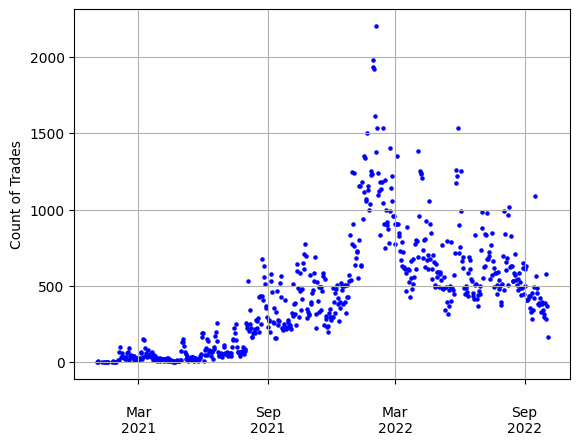

In [51]:
nft_trades["sell_date"] = pd.to_datetime(nft_trades["sell_date"])
ax = (
    nft_trades[["sell_date", "profit_usd"]]
    .groupby("sell_date")
    .count()
    .rename(columns={"profit_usd": "Count of Trades"})
    .loc["2021-01-01":].reset_index()
    .plot.scatter(x="sell_date", y="Count of Trades", grid=True, xlabel="", marker=".",color="b")
)
ax.xaxis.set_major_locator(mdates.MonthLocator([3, 9]))
ax.xaxis.set_major_formatter(mdates.DateFormatter("\n%b\n%Y"))
plt.show()

In [44]:
# keep float numbers only
trades = nft_trades[
    [
        "holding_period",
        "purchase_price_eth",
        "sell_price_eth",
        "profit_eth",
        "purchase_price_usd",
        "sell_price_usd",
        "profit_usd",
    ]
]
trades_array = trades.astype(float).values

# normalize
trades_array_norm = (trades_array - trades_array.mean()) / trades_array.std()

nft_labels = np.array(trades.columns).T

X = StandardScaler().fit_transform(trades_array_norm)

In [6]:
edge_model = GraphicalLassoCV()
edge_model.fit(X)

GraphicalLassoCV()

In [11]:
from sklearn import cluster

In [17]:
_, labels = affinity_propagation(edge_model.covariance_, random_state=0)
n_labels = labels.max()

In [20]:
for i in range(n_labels + 1):
    print("Cluster %i: %s" % ((i + 1), ", ".join(nft_labels[labels == i])))

Cluster 1: holding_period
Cluster 2: purchase_price_eth, sell_price_eth, purchase_price_usd, sell_price_usd
Cluster 3: profit_eth, profit_usd


In [21]:
af = AffinityPropagation(preference=-50, random_state=0).fit(X)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_

n_clusters_ = len(cluster_centers_indices)

print("Estimated number of clusters: %d" % n_clusters_)

MemoryError: Unable to allocate 555. GiB for an array with shape (272978, 272978) and data type float64